In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Audio
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

device = "cpu"
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")

    device = torch.device("cuda:0")



In [ ]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
    "dataset/targets_train_int8.npy"
)
X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
    "dataset/targets_test_int8.npy"
)

X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)


In [25]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean))
        self.register_buffer("std", torch.tensor(std))

    def forward(self, x):
        with torch.no_grad():
            x = x - self.mean
            x = x / self.std
        return x
    
class LoudnessNormalization(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        with torch.no_grad():
            mins = x.min(axis=2, keepdims=True).values
            maxs = x.max(axis=2, keepdims=True).values
            x = x - mins
            x = x / (maxs - mins)
        return x

mean = X_train.mean()
std = X_train.std()
normalization = Normalization(mean, std)
loudness_normalization = LoudnessNormalization()


In [ ]:
# Create the data set and dataloaders

config = {
    "batch_size": 16,
    "num_workers": 8,
    "learning_rate": 3e-4, # lower learning rate because the model is larger
    "num_epochs": 40,
}

num_workers = 0 if device == "cpu" else config["num_workers"]

X_train, X_test = np.expand_dims(X_train, axis=1), np.expand_dims(
    X_test, axis=1
)

train_dataset = TensorDataset(
    torch.from_numpy(X_train), torch.from_numpy(y_train)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test), torch.from_numpy(y_test)
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    drop_last=True,
    num_workers=0,
    pin_memory=True,
)


In [34]:
# Create the model

# increased depth of the network
n_filters = [1, 16, 16, 32, 32, 64, 64, 128, 128, 256]
classifier_width = 128
cnn_layers = []
output_size = 6

for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
    cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
    cnn_layers.append(nn.ReLU())
    cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# adaptive average pooling to obtain features
cnn_layers.append(nn.AdaptiveAvgPool1d(1))
cnn_layers.append(nn.Flatten())
model = nn.Sequential(
    loudness_normalization,
    normalization,
    *cnn_layers,
    nn.Linear(n_filters[-1], classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, output_size),
)
# No soft max as loss function expects logits

model = model.to(device)


In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
# cross entropy + softmax
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def loss_accuracy(model, dataloader):
    with torch.no_grad():
        losses = []
        accuracies = []
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y = y.float()
            targets = F.one_hot(y.long(), num_classes=6).float()
            y_pred = model(X)
            losses.append(criterion(y_pred, targets).item())
            accuracies.append(y_pred.argmax(axis=1).round().eq(y).sum().item() / y.shape[0])
        return np.mean(losses), np.mean(accuracies)


In [37]:
losses_train = []
losses_test = []

for epoch in range(config["num_epochs"]):
    pbar = tqdm(train_dataloader)
    for i, batch in enumerate(pbar):
        optimizer.zero_grad()
        batch = [tensor.to(device) for tensor in batch]
        inputs = batch[0].to(device)
        targets = batch[1].float().to(device)

        output = model(inputs)
        # one hot encode targets
        targets = F.one_hot(targets.long(), num_classes=6).float()
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        # because the dataset is so small we can compute stats over the whole dataset
        if i % 100 == 0:
            loss_train, accuracy_train = loss_accuracy(model, train_dataloader)
            loss_test, accuracy_test = loss_accuracy(model, test_dataloader)
            losses_train.append(loss_train)
            losses_test.append(loss_test)

        pbar.set_description(
            f"accuracy: {accuracy_train:.3f}, test_accuracy: {accuracy_test:.3f}"
        )

accuracy: 0.946, test_accuracy: 0.607: 100%|██████████| 375/375 [00:14<00:00, 25.47it/s]


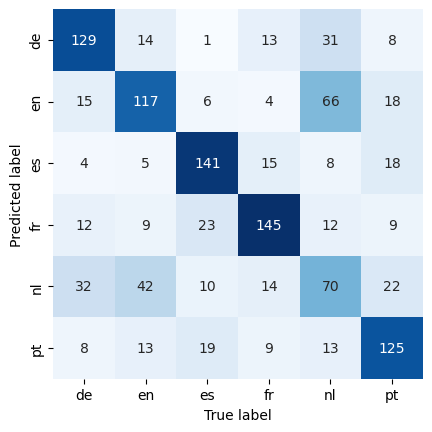

In [38]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


with torch.no_grad():
    y = []
    y_pred = []
    for batch in test_dataloader:
        X, y_batch = batch
        X = X.to(device)
        y_batch = y_batch.to(device)
        y_pred_batch = model(X).argmax(axis=1)
        y.extend(y_batch.cpu().numpy())
        y_pred.extend(y_pred_batch.cpu().numpy())

fig, ax = plt.subplots()

mat = confusion_matrix(y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, cmap="Blues")
ax.set_xlabel("True label")
ax.set_ylabel("Predicted label")
ax.set_xticklabels(languages)
ax.set_yticklabels(languages);

Dutch gets relatively often confused with English or German. This makes sense as all three are Germanic languages.
The model has some difficulty with seeing French as Spanish or Dutch.

In [39]:
# PCA plot of logits
from sklearn.decomposition import PCA

with torch.no_grad():
    y = []
    y_pred = []
    for batch in train_dataloader:
        X, y_batch = batch
        X = X.to(device)
        y_batch = y_batch.to(device)
        y_pred_batch = model(X)
        y.extend(y_batch.cpu().numpy())
        y_pred.extend(y_pred_batch.cpu().numpy())

y_pred = np.array(y_pred)

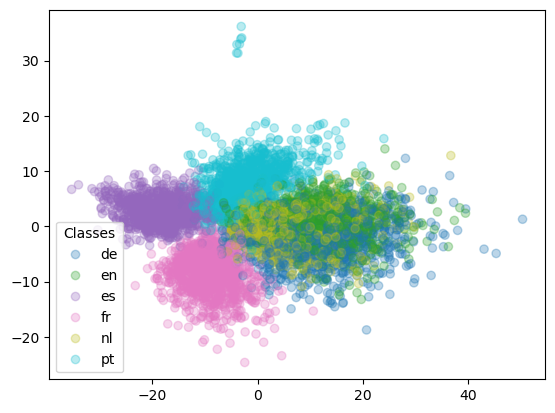

In [40]:
fig, ax = plt.subplots()
logits_pca = PCA(n_components=2).fit_transform(y_pred)
scatter = ax.scatter(*logits_pca.T, c=y, cmap="tab10", alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);

TCN model

In [46]:

import torch.nn as nn
import torch
import numpy as np


class temporal_block(nn.Module):
    #Create a class that construct a block using dilated convolution and residual connections.
    
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(temporal_block, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size, dilation=dilation
        )
        self.batch_norm1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size, dilation=dilation
        )
        self.batch_norm2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = nn.Conv1d(in_channels, out_channels, 1)
        self.do_downsample = in_channels != out_channels
        padding = (kernel_size - 1) * dilation
        # causal padding
        self.padding = nn.ConstantPad1d((padding, 0), 0.0)
        self.pooling = nn.MaxPool1d(2)

    def forward(self, x):
        # x shape: (batch, channels, time)
        # y shape: (batch, channels, time)
        residual = x
        y = self.relu(self.batch_norm1(self.conv1(x)))
        y = self.padding(y)
        y = self.batch_norm2(self.conv2(y))
        y = self.padding(y)
        if self.do_downsample:
            residual = self.downsample(residual)
        y += residual
        y = self.pooling(self.relu(y))
        return y


class TCN(nn.Module):
    def __init__(
        self,
        n_conv_layers,
        n_classifier_layers,
        n_classes,
        classifier_width,
        starting_channels=16,
    ):
        super(TCN, self).__init__()

        # Convolutional part, with residual connections.
        channel_sizes = [1] + list(starting_channels * 2 ** np.arange(n_conv_layers))
        # convert to list of ints
        channel_sizes = [int(x) for x in channel_sizes]
        layers = []
        for i in range(n_conv_layers):
            layers.append(
                temporal_block(
                    channel_sizes[i], channel_sizes[i + 1], 3, dilation=2**i
                )
            )

        # take average features over time. In this way,
        # the model can be used for variable length inputs.
        layers += [nn.AdaptiveAvgPool1d(1), nn.Flatten()]
        # collapse all dimensions except batch
        layers += [nn.Flatten()]
        layers.append(nn.Linear(channel_sizes[-1], classifier_width))
        layers.append(nn.ReLU())

        for i in range(n_classifier_layers - 1):
            layers.append(nn.Linear(classifier_width, classifier_width))
            layers.append(nn.ReLU())

        # projection head, no activation
        # because our loss function expects unnormalized logits
        layers.append(nn.Linear(classifier_width, n_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch, channels, time)
        # y shape: (batch, n_classes)
        y = self.model(x)
        return y


In [48]:
n_classes = 6
model = TCN(
    n_conv_layers=5,
    n_classifier_layers=2,
    n_classes=n_classes,
    classifier_width=64,
    starting_channels=8,
)
model = nn.Sequential(loudness_normalization, normalization, model)
model.to(device);

In [49]:
summary(model, (1, 40_000))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
LoudnessNormalization-1             [-1, 1, 40000]               0
     Normalization-2             [-1, 1, 40000]               0
            Conv1d-3             [-1, 8, 39998]              32
       BatchNorm1d-4             [-1, 8, 39998]              16
              ReLU-5             [-1, 8, 39998]               0
     ConstantPad1d-6             [-1, 8, 40000]               0
            Conv1d-7             [-1, 8, 39998]             200
       BatchNorm1d-8             [-1, 8, 39998]              16
     ConstantPad1d-9             [-1, 8, 40000]               0
           Conv1d-10             [-1, 8, 40000]              16
             ReLU-11             [-1, 8, 40000]               0
        MaxPool1d-12             [-1, 8, 20000]               0
   temporal_block-13             [-1, 8, 20000]               0
           Conv1d-14            [-1,

In [50]:
config = {
    "batch_size": 16,
    "num_workers": 8,
    "learning_rate": 3e-4, # lower learning rate because the model is larger
    "num_epochs": 40,
}

optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
# cross entropy + softmax
criterion = nn.CrossEntropyLoss().to(device)

In [52]:
losses_train = []
losses_test = []

for epoch in range(config["num_epochs"]):
    pbar = tqdm(train_dataloader)
    for i, batch in enumerate(pbar):
        optimizer.zero_grad()
        batch = [tensor.to(device) for tensor in batch]
        inputs = batch[0].to(device)
        targets = batch[1].float().to(device)

        output = model(inputs)
        # one hot encode targets
        targets = F.one_hot(targets.long(), num_classes=6).float()
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        # because the dataset is so small we can compute stats over the whole dataset
        if i % 100 == 0:
            loss_train, accuracy_train = loss_accuracy(model, train_dataloader)
            loss_test, accuracy_test = loss_accuracy(model, test_dataloader)
            losses_train.append(loss_train)
            losses_test.append(loss_test)

        pbar.set_description(
            f"accuracy: {accuracy_train:.3f}, test_accuracy: {accuracy_test:.3f}"
        )

  0%|          | 0/375 [00:01<?, ?it/s]


KeyboardInterrupt: 

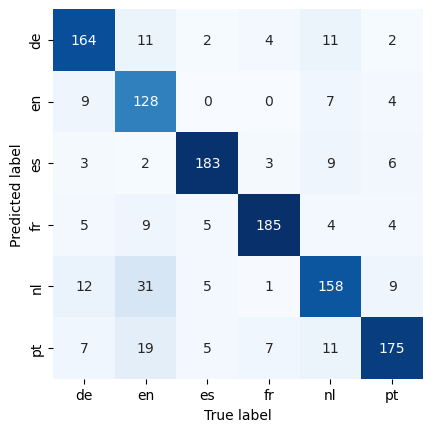

In [53]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


with torch.no_grad():
    y = []
    y_pred = []
    for batch in test_dataloader:
        X, y_batch = batch
        X = X.to(device)
        y_batch = y_batch.to(device)
        y_pred_batch = model(X).argmax(axis=1)
        y.extend(y_batch.cpu().numpy())
        y_pred.extend(y_pred_batch.cpu().numpy())

fig, ax = plt.subplots()

mat = confusion_matrix(y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, cmap="Blues")
ax.set_xlabel("True label")
ax.set_ylabel("Predicted label")
ax.set_xticklabels(languages)
ax.set_yticklabels(languages);

We can see that the Germanic languages are, on average, closer to eachother than the Latin Languages and vica versa.\
We can also see that Dutch is a hard Language for the model, as there is a lot of overlap with English and Portugese.